# HW Mod 4

### By: Garrick Hague

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
from scipy.stats import pearsonr


from eofs.xarray import Eof

import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
#                      chunks={'time':'500MB'})

# variables = ['Total_column_water_vapour_surface_Mixed_intervals_Average',
#         'Sea_surface_temperature_surface_Mixed_intervals_Average']

# #select the two needed variables every 4th point to get 1 degree resolution
# ds = ds[variables].sel(lat=slice(65, -65, 4), lon=slice(120, 300, 4))

# # Rounding lat to 2 decimal places
# latitudes = np.round(ds['lat'], 2)

# # Create a new DataArray with rounded latitudes
# rounded_latitudes = xr.DataArray(latitudes, dims='lat', coords={'lat': ds['lat']})

# # Replace the latitude coordinates in the existing DataArray
# ds['lat'] = rounded_latitudes

# # Saving data to file
# ds.to_netcdf('raw_data.nc')

# Loading filtered data
data = xr.open_dataset('raw_data.nc')

q_6_data = data

In [3]:
data

<xarray.Dataset>
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 ...
  * lon                                                        (lon) float32 ...
  * time                                                       (time) datetime64[ns] ...
    reftime                                                    (time) datetime64[ns] ...
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 ...
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

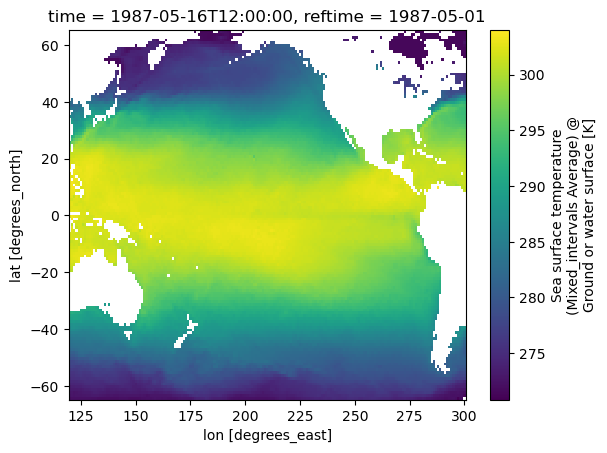

In [4]:
data['Sea_surface_temperature_surface_Mixed_intervals_Average'].isel(time=100).plot()


# Mask Land

## Having issues with this part of the code.

In [5]:
# OPeNDAP URL for land sea mask
url = 'https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'

# Open dataset with setting engine to netcdf
mask_data = xr.open_dataset(url, engine='netcdf4')

# to only have the LSM variable
mask = mask_data['LSM']

# select the needed variables every 4th point to get 1 degree resolution
mask = mask.sel(latitude=slice(64.75, -64.75, 4), longitude=slice(120, 300, 4))

# Rename the coordinates
mask = mask.rename({'latitude': 'lat', 'longitude': 'lon'})

# Making the mask have no time dimension and only being true and false values
mask = (mask == 0).squeeze(['time'], drop=True)

# Replace land values with NaN in the data
data = data.where(mask == 1)

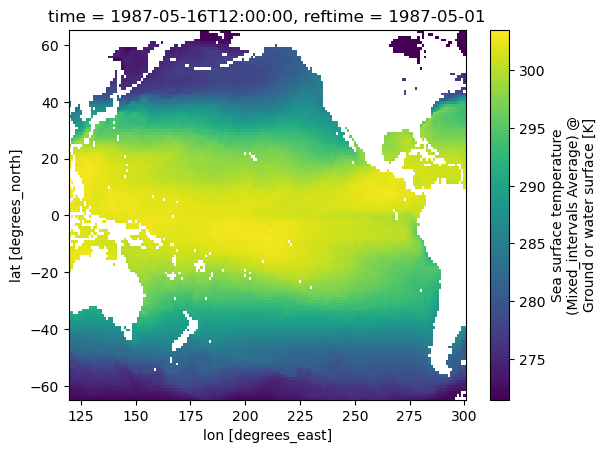

In [6]:
data['Sea_surface_temperature_surface_Mixed_intervals_Average'].isel(time=100).plot()

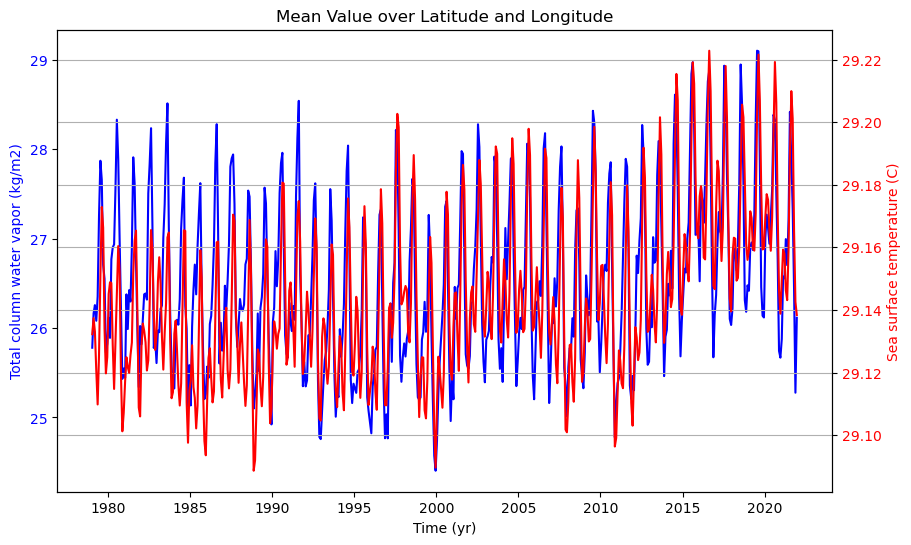

In [7]:
# Creating time series 
mean_data = data.mean(dim=['lat', 'lon'])


fig, ax1 = plt.subplots(figsize=(10, 6))

# Line plot for the first y-axis
ax1.plot(mean_data['time'], mean_data['Total_column_water_vapour_surface_Mixed_intervals_Average'], color='blue', label='Total column water vapour')
ax1.set_xlabel('Time (yr)')
ax1.set_ylabel('Total column water vapor (kg/m2)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating secondary y-axis
ax2 = ax1.twinx()
ax2.plot(mean_data['time'], mean_data['Sea_surface_temperature_surface_Mixed_intervals_Average']/10, color='red', label='Sea surface temperature')
ax2.set_ylabel('Sea surface temperature (C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Mean Value over Latitude and Longitude')
plt.grid(True)
plt.show()

## Part 2

2)  From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)

In [8]:
sst = data['Sea_surface_temperature_surface_Mixed_intervals_Average']

# Grouping data into months to find mean over each point
climatology = sst.sel(time=slice('1980-01-01','2020-12-01')).groupby('time.month').mean(dim='time')

# removing the mean monthly anomaly form the annual mean for each point 
anomalies = (sst.groupby('time.month')-climatology)

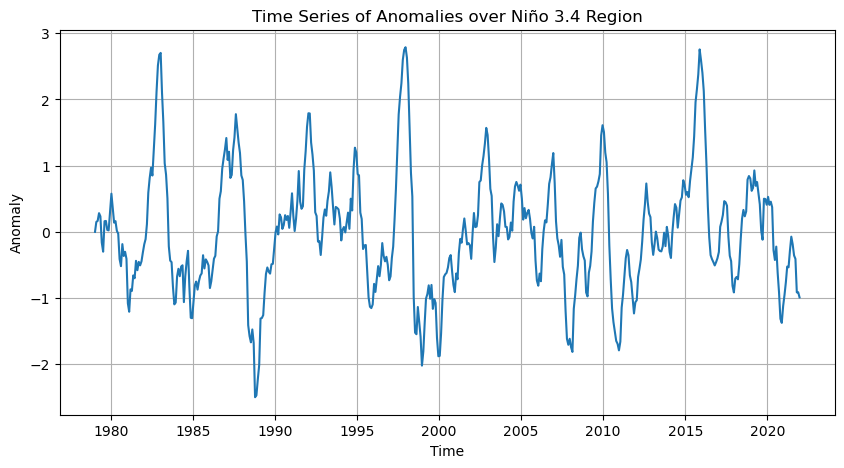

In [9]:
# Define latitude and longitude bounds for the Niño 3.4 region
lat_bounds = slice(5, -5)  # 5°N to 5°S
lon_bounds = slice(190, 240)  # 170°W to 120°W

# Extract subset of data for the Niño 3.4 region
nino34_anomalies = anomalies.sel(lat=lat_bounds, lon=lon_bounds)

# Calculate spatial mean over the Niño 3.4 region
nino34_anomalies_mean = nino34_anomalies.mean(dim=('lat', 'lon'))

# Plot the time series
plt.figure(figsize=(10, 5))
nino34_anomalies_mean.plot()
plt.title('Time Series of Anomalies over Niño 3.4 Region')
plt.xlabel('Time')
plt.ylabel('Anomaly')
plt.grid(True)
plt.show()


In [10]:
# -- Detorending
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# -- Running mean
ranm = anomalies.rolling(time=12, center=True).mean('time')
rdanm = detrend_dim(anomalies,'time',1)

In [11]:
# standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation

standardize = rdanm / rdanm.std(dim='time')

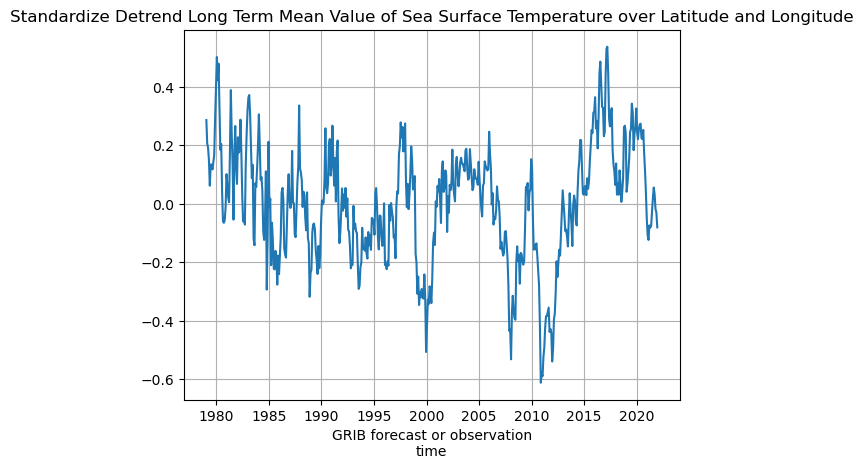

In [12]:
s_m = standardize.mean(dim=['lat', 'lon'])

s_m.plot()

plt.title('Standardize Detrend Long Term Mean Value of Sea Surface Temperature over Latitude and Longitude')
plt.grid(True)
plt.show()

### Pacific Decadal Oscillation (PDO)

# 3) Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.


In [13]:
# Get only the SST anomalies and squeeze any extra dims out
sst_anom = standardize 

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_anom.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_anom, weights=wgts)

pc1 = solver.pcs(npcs=1, pcscaling=1)

In [14]:
solver.eofs(neofs=1)

<xarray.DataArray 'eofs' (mode: 1, lat: 130, lon: 181)>
array([[[        nan,         nan,         nan, ...,  0.00127452,
          0.00124619,  0.00131072],
        [        nan,         nan,         nan, ...,  0.0014881 ,
          0.00159973,  0.0016282 ],
        [        nan,         nan,         nan, ...,  0.00161625,
          0.00166481,  0.00133592],
        ...,
        [-0.00094954, -0.00111486, -0.0009929 , ...,  0.00395774,
                 nan,         nan],
        [-0.00197639, -0.00157898, -0.00129718, ...,  0.00365689,
                 nan,  0.00180116],
        [-0.00203607, -0.00178521, -0.00158994, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * mode     (mode) int64 0
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
Attributes:
    long_name:  empirical_orthogonal_functions

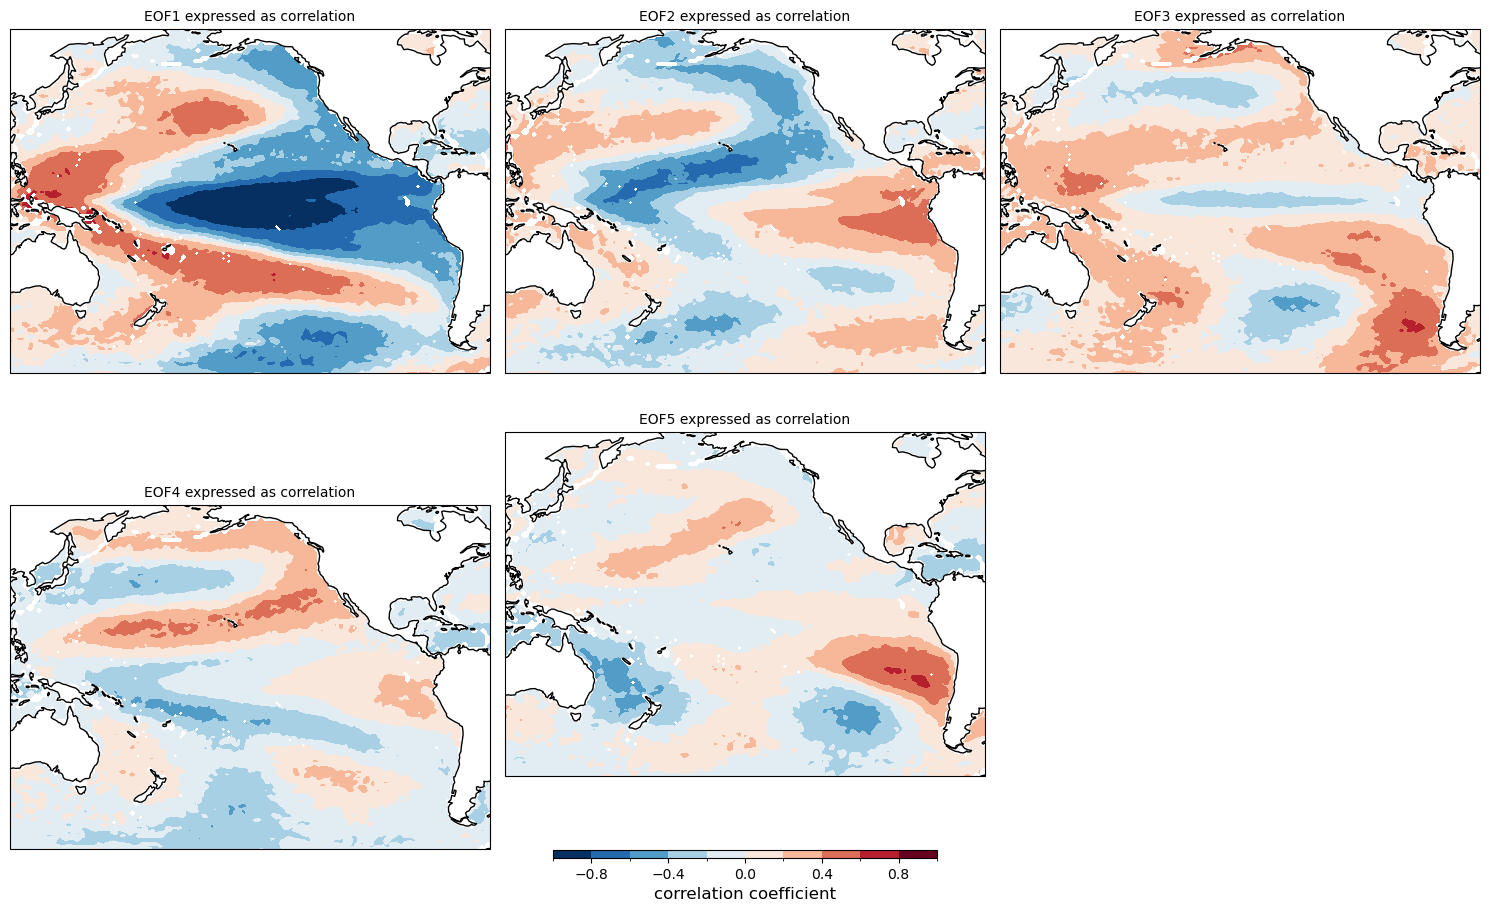

In [15]:
plt.figure(figsize=(15, 10))


# Loop over the first 5 EOFs
for i in range(5):
    # Get the i-th EOF expressed as correlation
    eof_i = solver.eofsAsCorrelation(neofs=i+1)
    
    # Plot the i-th EOF expressed as correlation
    clevs = np.linspace(-1, 1, 11)
    ax = plt.subplot(2, 3, i+1, projection=ccrs.PlateCarree(central_longitude=190))
    fill = eof_i[i].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                                  add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    ax.set_title(f'EOF{i+1} expressed as correlation', fontsize=10)
    
# Add colorbar
cb = plt.colorbar(fill, ax=ax, orientation='horizontal', aspect=50, shrink=0.8)
cb.set_label('correlation coefficient', fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'PC1 Time Series')

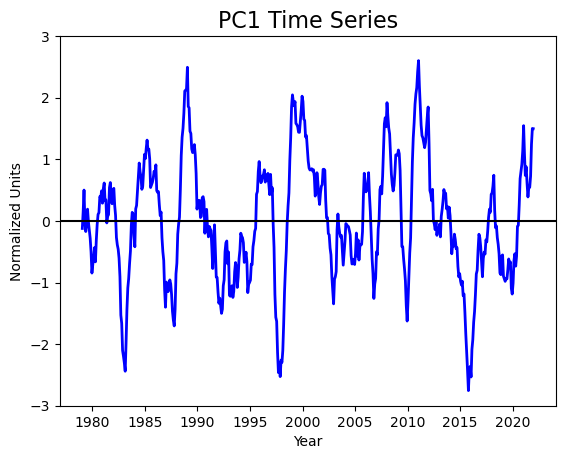

In [16]:
# Plot the leading PC time series.
plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

# 4) Plot the percent of variance explained by the first 10 EOFs.

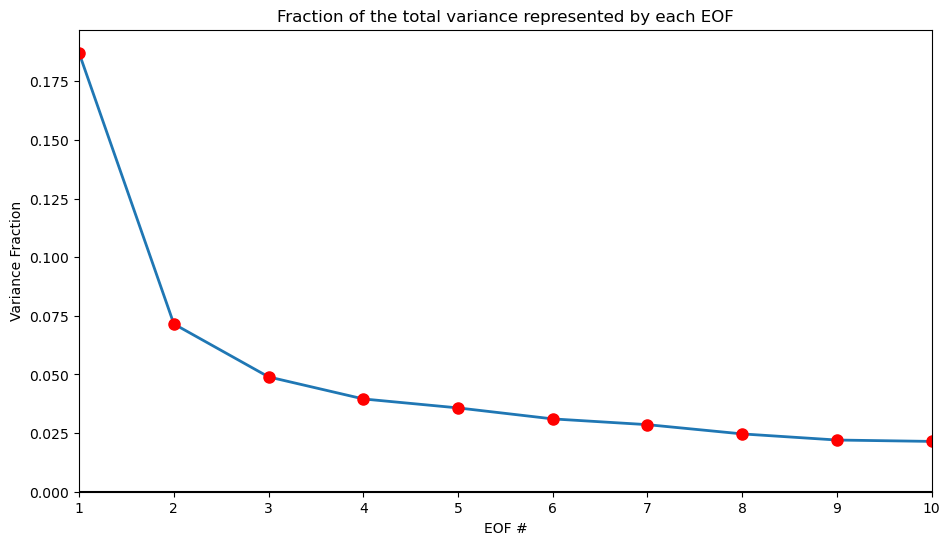

In [17]:
varfrac = solver.varianceFraction()

# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

plt.show()

# 5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.

In [18]:
# Initialize an empty dictionary to store the products of PCs and EOFs
eofs_ = {}  

for i in range(5):
    eofs_[i+1] = (solver.pcs(npcs=i+1, pcscaling=1)) * (solver.eofs(neofs=i+1))

# Sum up the products to reconstruct the field
reconstruction = standardize.mean(dim='time') + sum(eofs_.values())


In [19]:
mean_rec = reconstruction.mean(dim=['lat', 'lon'])
stand_mean = standardize.mean(dim=['lat', 'lon'])

xr.corr(stand_mean, mean_rec, dim='time')

<xarray.DataArray (mode: 1)>
array([0.61550755])
Coordinates:
  * mode     (mode) int64 0

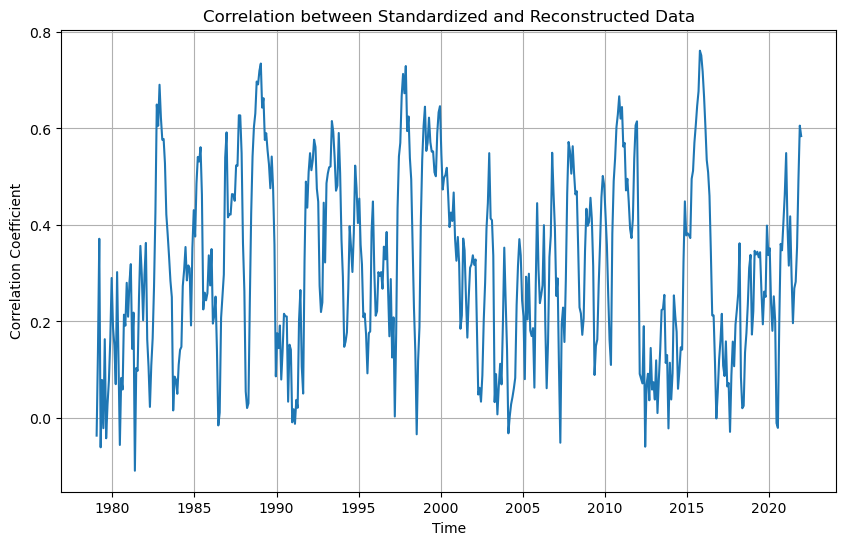

In [20]:
# Compute correlation
correlation = xr.corr(standardize, reconstruction, dim=['lat', 'lon'])

# Plot correlation time series
plt.figure(figsize=(10, 6))
correlation.plot()

# Add title and labels
plt.title("Correlation between Standardized and Reconstructed Data")
plt.xlabel("Time")
plt.ylabel("Correlation Coefficient")

# Add grid
plt.grid(True)

# Show plot
plt.show()

# 6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean precipitation anomalies (don't mask these over land for the plot).  See anything interesting?

In [21]:
tcwv = q_6_data['Total_column_water_vapour_surface_Mixed_intervals_Average']

# Grouping data into months to find mean over each point
climatology = tcwv.sel(time=slice('1980-01-01','2020-12-01')).groupby('time.month').mean(dim='time')

# removing the mean monthly anomaly form the annual mean for each point 
tcwv_anom = (tcwv.groupby('time.month')-climatology)

# -- Running mean
ranm = tcwv_anom.rolling(time=12, center=True).mean('time')
rdanm = detrend_dim(tcwv_anom,'time',1)

# standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation

tcwv_standardize = rdanm / rdanm.std(dim='time')

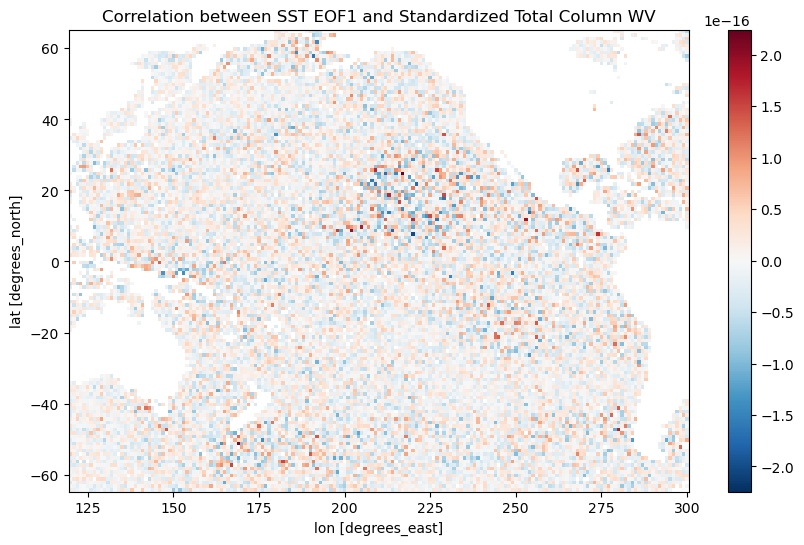

In [22]:
# Plot correlation time series
plt.figure(figsize=(10, 6))

xr.corr(tcwv_standardize, solver.eofs(neofs=1), dim='time').plot()

# Add title and labels
plt.title("Correlation between SST EOF1 and Standardized Total Column WV")


# Show plot
plt.show()

#### I can only see that there are no correlation patterns present in the data for question 6.